# Stock Price Prediction
https://www.youtube.com/watch?v=QIUxPv5PJOY&list=WL&index=7&t=225s

# Imports

In [1]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
print("Import successful")

Using TensorFlow backend.


Import successful


# Processing data

In [2]:
df=web.DataReader("MS", data_source="yahoo", start="2010-01-01", end = "2020-08-01")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.969999,30.629999,30.700001,30.910000,20371000.0,25.759523
2010-01-05,32.130001,30.930000,31.010000,32.040001,22523400.0,26.701244
2010-01-06,32.590000,31.790001,31.969999,32.450001,17028500.0,27.042919
2010-01-07,33.270000,32.270000,32.459999,32.919998,18693000.0,27.434603
2010-01-08,32.820000,31.980000,32.599998,32.250000,15993400.0,26.876251
...,...,...,...,...,...,...
2020-07-27,51.570000,49.730000,49.910000,51.320000,12087100.0,50.964951
2020-07-28,51.220001,50.209999,50.830002,50.259998,7287900.0,49.912281
2020-07-29,50.660000,49.880001,50.270000,50.590000,8074300.0,50.240002


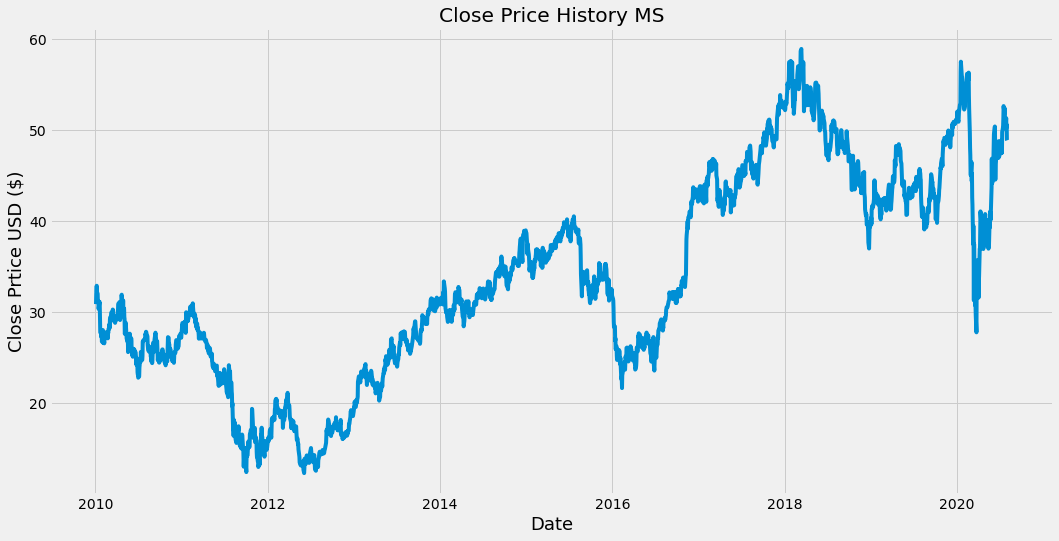

In [3]:
plt.figure(figsize=(16,8))
plt.title("Close Price History MS")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Prtice USD ($)", fontsize=18)
plt.show()


In [4]:
data=df.filter(["Close"])
dataSet=data.values #creates numpy array
TrainDataLen=math.ceil(len(dataSet)*.8)

#scaling
scaler=MinMaxScaler(feature_range=(0,1))
scaledData=scaler.fit_transform(dataSet)

In [5]:
TrainData=scaledData[0:TrainDataLen]
TestData=scaledData[TrainDataLen -60: ]
TrainData

array([[0.39849624],
       [0.42277124],
       [0.43157897],
       ...,
       [0.82513428],
       [0.80687429],
       [0.80622985]])

In [6]:
xTrain=[]#past x days
yTrain=[]#prediction target

for i in range(60, len(TrainData)): #give 60 days of data=> predict 61th day
    xTrain.append(TrainData[i-60:i, 0])
    yTrain.append(TrainData[i, 0])
    
xTest=[]
yTest=dataSet[TrainDataLen:,:]
for i in range(60, len(TestData)): #give 60 days of data=> predict 61th day
    xTest.append(TestData[i-60:i, 0])
xTest, yTest=np.array(xTest), np.array(yTest)
xTest=np.reshape(xTest,(xTest.shape[0], xTest.shape[1], 1))

In [7]:
xTrain, yTrain=np.array(xTrain), np.array(yTrain)
#the lstm model expects 3 dim  but xtrain has only 2
xTrain=np.reshape(xTrain,(xTrain.shape[0], xTrain.shape[1], 1))


# Model

In [8]:
model=Sequential()
Neurons1=128
Neurons2=56  #more did nor tly improve the results
model.add(LSTM(Neurons1,return_sequences=True, input_shape=(xTrain.shape[1],1)))
model.add(LSTM(Neurons2,return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="MSE")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 56)                41440     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1425      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 109,451
Trainable params: 109,451
Non-trainable params: 0
_________________________________________________________________


# Training

In [9]:
try:
    model=keras.models.load_model("MS1.h5")
    print("Trainings data found")
except:
    print("training")
    model.fit(xTrain, yTrain, batch_size=1, epochs=5)
    model.save("MS1.h5")

Trainings data found


# Predicitions

In [10]:
#get the real values
predictions = model.predict(xTest)
#scaler=MinMaxScaler(feature_range=(0,1)) #already defined above
#scaled = scaler.fit(predictions)
predictions = scaler.inverse_transform(predictions)


In [11]:
model.evaluate(xTest, yTest)

532/532 [==============================] - 0s 892us/sample - loss: 1988.8856


1988.8855769795582

In [12]:
rsme= np.sqrt(np.mean(predictions-yTest)**2)#root mean squared error
rsme

0.1792686146901066

# Plot the data

C:\Users\nicol\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


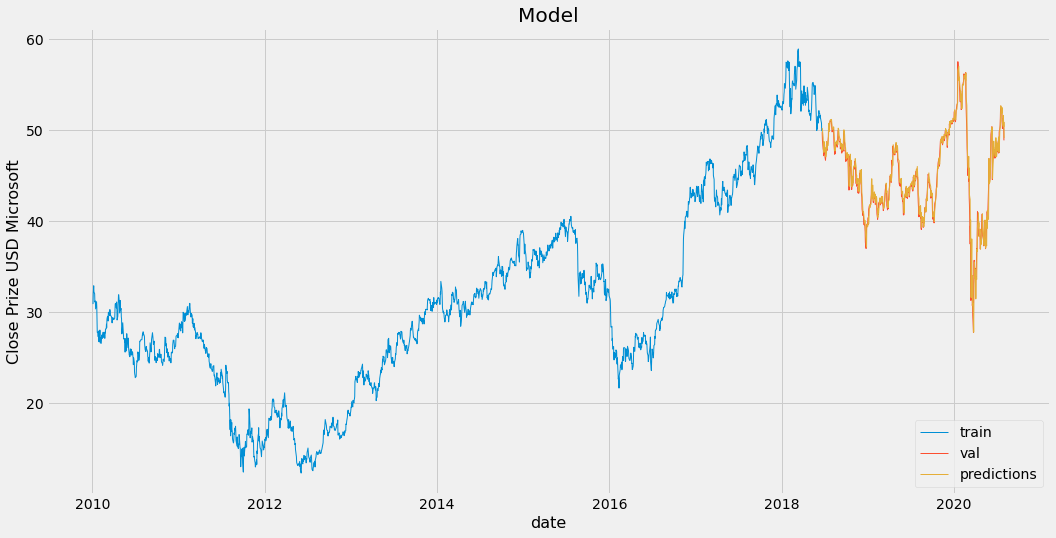

In [13]:
train=data[:TrainDataLen]
valid=data[TrainDataLen:]
valid["predictions"]=predictions
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close Prize USD Microsoft", fontsize=16)
plt.plot(train["Close"],linewidth=1)
plt.plot(valid[["Close", "predictions"]],linewidth=1)
plt.legend(["train", "val", "predictions"], loc="lower right")
plt.show()

In [14]:
valid["dif(%)"]=((valid["Close"]-valid["predictions"])/valid["Close"])*100
valid["difABS(%)"]=abs(valid["dif(%)"])
valid

C:\Users\nicol\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\nicol\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,predictions,dif(%),difABS(%)
Date,,,,
2018-06-21,49.790001,50.230003,-0.883716,0.883716
2018-06-22,48.889999,50.086250,-2.446821,2.446821
2018-06-25,47.930000,49.167393,-2.581666,2.581666
2018-06-26,47.790001,48.286625,-1.039180,1.039180
2018-06-27,47.189999,48.215496,-2.173125,2.173125
...,...,...,...,...
2020-07-27,51.320000,50.416794,1.759949,1.759949
2020-07-28,50.259998,51.617191,-2.700344,2.700344
2020-07-29,50.590000,50.350498,0.473418,0.473418


In [15]:
valid.describe()

,Close,predictions,dif(%),difABS(%)
count,532.000000,532.000000,532.000000,532.000000
mean,45.058402,45.237671,-0.433822,1.736782
std,4.770851,4.783583,2.745655,2.169120
min,27.809999,27.820732,-20.246141,0.000985
25%,41.987501,42.187200,-1.566683,0.510027
50%,44.535000,44.804356,-0.378504,1.145757
75%,48.480000,48.699114,0.685738,2.139318
max,57.509998,57.009399,16.253067,20.246141


# Feedback
Apple:
being 3.3%of on average is way to high for a stock environment (apple   code = AAPL, Apple1.h5)

Microsoft: mean dif is better with MS, but a max dif of over 15% is way to huge (Microsoft code=MS, MS1.h5)